In [1]:
import pickle
import pandas as pd
import requests
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import numpy as np
from pathlib import Path
from collections import Counter
np.random.seed(2018)

from sklearn.metrics import confusion_matrix, accuracy_score

import nltk

pre-processing

In [2]:
ham_corpus = []

for path in Path('All enron unzip').rglob('*.ham.txt'):
        with open(path, errors='ignore') as f_input:
            ham_corpus.append(f_input.read())
df1 = pd.DataFrame(ham_corpus, columns=['email'])
df1

,email
0,Subject: christmas tree farm pictures\n
1,"Subject: vastar resources , inc .\ngary , prod..."
2,Subject: calpine daily gas nomination\n- calpi...
3,Subject: re : issue\nfyi - see note below - al...
4,Subject: meter 7268 nov allocation\nfyi .\n- -...
...,...
15040,Subject: tw weekend scheduled volumes\nmarch 2...
15041,"Subject: fw : re ivanhoe e . s . d\nfyi , kim ..."
15042,"Subject: fw : abandoned pipe ownership\nfyi , ..."
15043,"Subject: fw : tw question in amarillo\nfyi , k..."


In [3]:
df1['spam']=[0]*df1.shape[0]
df1

,email,spam
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
2,Subject: calpine daily gas nomination\n- calpi...,0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0
...,...,...
15040,Subject: tw weekend scheduled volumes\nmarch 2...,0
15041,"Subject: fw : re ivanhoe e . s . d\nfyi , kim ...",0
15042,"Subject: fw : abandoned pipe ownership\nfyi , ...",0
15043,"Subject: fw : tw question in amarillo\nfyi , k...",0


In [4]:
spam_corpus = []

for path in Path('All enron unzip').rglob('*spam.txt'):
        with open(path, errors='ignore') as f_input:
            spam_corpus.append(f_input.read())
df2 = pd.DataFrame(spam_corpus, columns=['email'])
df2

,email
0,Subject: dobmeos with hgh my energy level has ...
1,Subject: your prescription is ready . . oxwq s...
2,Subject: get that new car 8434\npeople nowthe ...
3,"Subject: await your response\ndear partner ,\n..."
4,"Subject: coca cola , mbna america , nascar par..."
...,...
12666,Subject: = ? iso - 8859 - 1 ? q ? good _ news ...
12667,Subject: all prescript medicines are on specia...
12668,Subject: the next generation online pharmacy ....
12669,Subject: bloow in 5 - 10 times the time\nlearn...


In [5]:
df2['spam']=[1]*df2.shape[0]
df2

,email,spam
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434\npeople nowthe ...,1
3,"Subject: await your response\ndear partner ,\n...",1
4,"Subject: coca cola , mbna america , nascar par...",1
...,...,...
12666,Subject: = ? iso - 8859 - 1 ? q ? good _ news ...,1
12667,Subject: all prescript medicines are on specia...,1
12668,Subject: the next generation online pharmacy ....,1
12669,Subject: bloow in 5 - 10 times the time\nlearn...,1


In [6]:
df = pd.concat([df1,df2],ignore_index=True)
# df = df.sample(frac=1).reset_index(drop=True)
df

,email,spam
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
2,Subject: calpine daily gas nomination\n- calpi...,0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0
...,...,...
27711,Subject: = ? iso - 8859 - 1 ? q ? good _ news ...,1
27712,Subject: all prescript medicines are on specia...,1
27713,Subject: the next generation online pharmacy ....,1
27714,Subject: bloow in 5 - 10 times the time\nlearn...,1


k-fold:

In [7]:
df1 = df

In [170]:
k_fold_indexs = pd.DataFrame(columns = ['train_index','test_index'])

from sklearn.model_selection import KFold  
import numpy as np  
X = df['email']  
y = df['spam'] 
kf = KFold(n_splits=10,shuffle=True) 
i = 0
for train_index , test_index in kf.split(X):  
    k_fold_indexs.at[i,'train_index'] = train_index
    k_fold_indexs.at[i,'test_index'] = test_index
    i+=1
k_fold_indexs

,train_index,test_index
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[16, 29, 35, 37, 43, 51, 53, 84, 105, 133, 139..."
1,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 15, 38, 40, 60, 62, 70, 94, 107, 112, 121,..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[11, 24, 28, 46, 57, 64, 67, 69, 88, 90, 93, 1..."
3,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...","[1, 12, 20, 21, 22, 26, 42, 47, 68, 74, 78, 80..."
4,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 15, 1...","[5, 8, 14, 34, 49, 52, 61, 63, 65, 71, 82, 108..."
5,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 36, 41, 45, 56, 76, 79, 83, 87, 127, 140, ..."
6,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...","[7, 19, 23, 33, 48, 86, 99, 122, 147, 150, 152..."
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...","[10, 18, 27, 30, 31, 32, 39, 54, 77, 89, 91, 9..."
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[17, 50, 55, 58, 66, 72, 75, 81, 85, 92, 102, ..."
9,"[1, 2, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17,...","[0, 3, 6, 9, 13, 25, 44, 59, 73, 95, 97, 100, ..."


In [25]:
# indexs =  list(k_fold_indexs['train_index'][0])
train = df.loc[list(k_fold_indexs['train_index'][0])]
test = df.loc[list(k_fold_indexs['test_index'][0])]

In [26]:
train

,email,spam
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
2,Subject: calpine daily gas nomination\n- calpi...,0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0
...,...,...
27711,Subject: = ? iso - 8859 - 1 ? q ? good _ news ...,1
27712,Subject: all prescript medicines are on specia...,1
27713,Subject: the next generation online pharmacy ....,1
27714,Subject: bloow in 5 - 10 times the time\nlearn...,1


In `train`, the rows with indexs <15045 are tf of ham emails; indexs>=15045 are tf of spam emails. Thus split the `train` dataset into `ham_train` and `spam_train`

In [27]:
ham_train = df[:15045]
ham_train

,email,spam
2772,Subject: re : boat\ni believe the boat is 18 t...,0
2773,Subject: noms / actual flow for 3 / 19 / 01\nw...,0
2774,"Subject: hpl nom for march 21 , 2001\n( see at...",0
2775,Subject: re : noms / actual flow for 3 / 19 / ...,0
2776,Subject: ces changes\ngulf energy pipeline\nte...,0
...,...,...
15040,Subject: tw weekend scheduled volumes\nmarch 2...,0
15041,"Subject: fw : re ivanhoe e . s . d\nfyi , kim ...",0
15042,"Subject: fw : abandoned pipe ownership\nfyi , ...",0
15043,"Subject: fw : tw question in amarillo\nfyi , k...",0


In [28]:
spam_train = df[15045:27716]
spam_train

,email,spam
15045,Subject: dobmeos with hgh my energy level has ...,1
15046,Subject: your prescription is ready . . oxwq s...,1
15047,Subject: get that new car 8434\npeople nowthe ...,1
15048,"Subject: await your response\ndear partner ,\n...",1
15049,"Subject: coca cola , mbna america , nascar par...",1
...,...,...
27711,Subject: = ? iso - 8859 - 1 ? q ? good _ news ...,1
27712,Subject: all prescript medicines are on specia...,1
27713,Subject: the next generation online pharmacy ....,1
27714,Subject: bloow in 5 - 10 times the time\nlearn...,1


In [29]:
# This chunk takes a few minuts
ham_freqdict = {}
for i in ham_train.index:
    fdist = dict(FreqDist(word.lower() for word in word_tokenize(ham_train.email[i])))
    ham_freqdict = dict(Counter(ham_freqdict)+Counter(fdist))
ham_freqdict

{'subject': 21978,
 ':': 100401,
 're': 8160,
 'boat': 19,
 'i': 31692,
 'believe': 1161,
 'the': 163492,
 'is': 33204,
 '18': 1803,
 'to': 114472,
 '19': 1971,
 'ft': 292,
 'long': 2040,
 'and': 75307,
 'do': 5057,
 'have': 21190,
 'a': 58332,
 'cover': 647,
 '.': 243751,
 'will': 22020,
 'bring': 608,
 'information': 4640,
 'with': 24732,
 'me': 8350,
 'tomorrow': 941,
 'for': 41966,
 'anymore': 40,
 'questions': 3159,
 'recently': 686,
 'took': 583,
 'it': 21138,
 'shop': 78,
 'get': 4204,
 'ready': 398,
 'this': 23742,
 'season': 362,
 'salesman': 3,
 'said': 10545,
 'looked': 175,
 'brand': 87,
 'new': 8867,
 'has': 11215,
 'battery': 11,
 'everything': 387,
 'runs': 133,
 'perfectly': 29,
 'call': 3895,
 'if': 12919,
 'you': 29197,
 'want': 2182,
 'take': 2397,
 'look': 1946,
 'at': 19346,
 'briant': 1,
 '66459': 1,
 'noms': 94,
 '/': 90586,
 'actual': 392,
 'flow': 627,
 '3': 7394,
 '01': 6712,
 'we': 22333,
 'agree': 508,
 'nom': 259,
 '-': 233369,
 'forwarded': 2652,
 'by': 18

In [30]:
# ham_freqdict_backup = ham_freqdict

In [31]:
def avefreq(x, length):
    y = {}
    for key in x:
        y[key]=x[key]/length
    return y

In [91]:
ham_freq = avefreq(ham_freqdict,ham_train.shape[0])
# ham_freq = dict(sorted(avefreq(ham_freqdict,ham_train.shape[0]).items()))
ham_freq

{'subject': 1.7907602053287706,
 ':': 8.180640430212662,
 're': 0.6648741139085798,
 'boat': 0.0015481137456204678,
 'i': 2.58225372769494,
 'believe': 0.0945978978244928,
 'the': 13.321274342051659,
 'is': 2.7054509899780004,
 '18': 0.14690784649230018,
 'to': 9.327140878350852,
 '19': 0.160596431190418,
 'ft': 0.023792063880061925,
 'long': 0.16621852847714494,
 'and': 6.135989570602135,
 'do': 0.4120426953475108,
 'have': 1.7265542247209322,
 'a': 4.75287215839648,
 'cover': 0.052717347021918035,
 '.': 19.86075124256498,
 'will': 1.7941823515033,
 'bring': 0.04953963985985497,
 'information': 0.37806567261468266,
 'with': 2.0151552187729163,
 'me': 0.6803552513647845,
 'tomorrow': 0.07667237024362422,
 'for': 3.4193758657215025,
 'anymore': 0.003259186832885195,
 'questions': 0.2573942801271083,
 'recently': 0.055895054183981094,
 'took': 0.04750264808930172,
 'it': 1.7223172818381813,
 'shop': 0.006355414324126131,
 'get': 0.34254053613623403,
 'ready': 0.03242890898720769,
 'this'

In [89]:
ham_words = list(ham_freqdict.keys())
ham_words

['subject',
 ':',
 're',
 'boat',
 'i',
 'believe',
 'the',
 'is',
 '18',
 'to',
 '19',
 'ft',
 'long',
 'and',
 'do',
 'have',
 'a',
 'cover',
 '.',
 'will',
 'bring',
 'information',
 'with',
 'me',
 'tomorrow',
 'for',
 'anymore',
 'questions',
 'recently',
 'took',
 'it',
 'shop',
 'get',
 'ready',
 'this',
 'season',
 'salesman',
 'said',
 'looked',
 'brand',
 'new',
 'has',
 'battery',
 'everything',
 'runs',
 'perfectly',
 'call',
 'if',
 'you',
 'want',
 'take',
 'look',
 'at',
 'briant',
 '66459',
 'noms',
 '/',
 'actual',
 'flow',
 '3',
 '01',
 'we',
 'agree',
 'nom',
 '-',
 'forwarded',
 'by',
 'david',
 'avila',
 'lsp',
 'enserch',
 'us',
 'on',
 '03',
 '20',
 '2001',
 '24',
 'pm',
 "''",
 'eileen',
 'ponton',
 '``',
 '10',
 '05',
 '59',
 'am',
 '@',
 'tu',
 ',',
 'charlie',
 'stone',
 'texas',
 'utilities',
 'melissa',
 'jones',
 'hpl',
 'scheduling',
 'enron',
 'com',
 'liz',
 'bellamy',
 'cc',
 'date',
 'mcf',
 'mmbtu',
 '60',
 '000',
 '944',
 '61',
 '562',
 'btu',
 '=',

In [33]:
# This chunk takes a few minuts
spam_freqdict = {}
for i in spam_train.index:
    fdist = dict(FreqDist(word.lower() for word in word_tokenize(spam_train.email[i])))
    spam_freqdict = dict(Counter(spam_freqdict)+Counter(fdist))
spam_freqdict

{'subject': 14165,
 ':': 53228,
 'dobmeos': 1,
 'with': 15957,
 'hgh': 57,
 'my': 6712,
 'energy': 1147,
 'level': 363,
 'has': 5917,
 'gone': 156,
 'up': 3645,
 '!': 24455,
 'stukm': 1,
 'introducing': 81,
 'doctor': 313,
 '-': 74103,
 'formulated': 54,
 'human': 191,
 'growth': 975,
 'hormone': 35,
 'also': 2317,
 'called': 235,
 'is': 26281,
 'referred': 54,
 'to': 66934,
 'in': 36690,
 'medical': 528,
 'science': 123,
 'as': 13972,
 'the': 86217,
 'master': 140,
 '.': 181071,
 'it': 11985,
 'very': 1937,
 'plentiful': 1,
 'when': 1976,
 'we': 14502,
 'are': 13684,
 'young': 212,
 ',': 118900,
 'but': 3792,
 'near': 284,
 'age': 395,
 'of': 56874,
 'twenty': 277,
 'one': 4714,
 'our': 12745,
 'bodies': 58,
 'begin': 295,
 'produce': 171,
 'less': 748,
 'by': 8854,
 'time': 4433,
 'forty': 42,
 'nearly': 175,
 'everyone': 304,
 'deficient': 3,
 'and': 58851,
 'at': 8495,
 'eighty': 27,
 'production': 688,
 'normally': 99,
 'diminished': 4,
 'least': 349,
 '90': 1077,
 '95': 1613,
 '%

In [90]:
spam_freq = avefreq(spam_freqdict,spam_train.shape[0])
# spam_freq = dict(sorted(avefreq(spam_freqdict,spam_train.shape[0]).items()))
spam_freq

{'subject': 1.117907031804909,
 ':': 4.200773419619604,
 'dobmeos': 7.892036934732854e-05,
 'with': 1.2593323336753215,
 'hgh': 0.004498461052797727,
 'my': 0.5297135190592692,
 'energy': 0.09052166364138584,
 'level': 0.028648094073080263,
 'has': 0.46697182542814303,
 'gone': 0.012311577618183253,
 'up': 0.2876647462710126,
 '!': 1.9299976323889196,
 'stukm': 7.892036934732854e-05,
 'introducing': 0.006392549917133612,
 'doctor': 0.024702075605713834,
 '-': 5.8482361297450876,
 'formulated': 0.004261699944755741,
 'human': 0.015073790545339753,
 'growth': 0.07694736011364534,
 'hormone': 0.002762212927156499,
 'also': 0.18285849577776023,
 'called': 0.018546286796622208,
 'is': 2.0741062268171415,
 'referred': 0.004261699944755741,
 'to': 5.282456001894089,
 'in': 2.895588351353484,
 'medical': 0.04166995501538947,
 'science': 0.009707205429721411,
 'as': 1.1026754005208745,
 'the': 6.804277484018625,
 'master': 0.011048851708625997,
 '.': 14.290190198090126,
 'it': 0.945860626627732

In [40]:
spam_words = list(spam_freqdict.keys())
spam_words

['subject',
 ':',
 'dobmeos',
 'with',
 'hgh',
 'my',
 'energy',
 'level',
 'has',
 'gone',
 'up',
 '!',
 'stukm',
 'introducing',
 'doctor',
 '-',
 'formulated',
 'human',
 'growth',
 'hormone',
 'also',
 'called',
 'is',
 'referred',
 'to',
 'in',
 'medical',
 'science',
 'as',
 'the',
 'master',
 '.',
 'it',
 'very',
 'plentiful',
 'when',
 'we',
 'are',
 'young',
 ',',
 'but',
 'near',
 'age',
 'of',
 'twenty',
 'one',
 'our',
 'bodies',
 'begin',
 'produce',
 'less',
 'by',
 'time',
 'forty',
 'nearly',
 'everyone',
 'deficient',
 'and',
 'at',
 'eighty',
 'production',
 'normally',
 'diminished',
 'least',
 '90',
 '95',
 '%',
 'advantages',
 'increased',
 'muscle',
 'strength',
 'loss',
 'body',
 'fat',
 'bone',
 'density',
 'lower',
 'blood',
 'pressure',
 'quickens',
 'wound',
 'healing',
 'reduces',
 'cellulite',
 'improved',
 'vision',
 'wrinkle',
 'disappearance',
 'skin',
 'thickness',
 'texture',
 'levels',
 'sleep',
 'emotional',
 'stability',
 'memory',
 'mental',
 'aler

In [36]:
test

,email,spam
8,Subject: king ranch\nthere are two fields of g...,0
13,Subject: unify close schedule\nthe following i...,0
18,Subject: hpl fuel gas buy - back for december ...,0
25,"Subject: out on vacation\nfyi ,\ni will be out...",0
30,Subject: january production estimate\ndaren / ...,0
...,...,...
27675,Subject: we are the only online pharmacy offer...,1
27693,Subject: = ? iso - 8859 - 1 ? q ? vlagrr = eo ...,1
27697,Subject: re [ 5 ] : question about her cds\nmu...,1
27703,Subject: everything you need for beautiful har...,1


In [48]:
words = list(set(ham_words+spam_words))

In [49]:
len(words) == len(ham_words)+len(spam_words)

False

In [72]:
ham_union_spam_words = set(ham_words)|set(spam_words)
ham_and_spam_words = set(ham_words).intersection(spam_words)
ham_minus_spam_words = set(ham_words)-set(spam_words)
spam_minus_ham_words = set(spam_words)-set(ham_words)

True
True
True


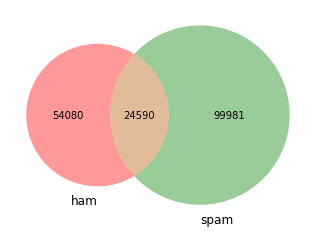

In [80]:
# assessment

print(len(ham_union_spam_words) == len(ham_minus_spam_words)+len(spam_words))
print(len(ham_union_spam_words) == len(spam_minus_ham_words)+len(ham_words))
print(len(ham_union_spam_words) == -len(ham_and_spam_words)+len(spam_words)+len(ham_words))

## Venn Diagram
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
venn2(subsets = (len(ham_words), len(spam_words), len(ham_and_spam_words)), set_labels = ('ham', 'spam'))
plt.show()

In [102]:
#  fill the keys in subtraction with freqency 0 and sort them so two vectors have same keys in same order
for key in ham_union_spam_words:
    if key not in ham_freq.keys():
        ham_freq[key] = 0
    if key not in spam_freq.keys():
        spam_freq[key] = 0
len(ham_freq) == len(spam_freq)

True

In [105]:
ham_freq = dict(sorted(ham_freq.items()))
spam_freq = dict(sorted(spam_freq.items()))

In [142]:
for i in list(test.index):
    v = dict(FreqDist(word.lower() for word in word_tokenize(test.email[i])))
    for key in ham_union_spam_words:
        if key not in v.keys():
            v[key] = 0
    v = dict(sorted(v.items()))
    ham_score = 0
    spam_score = 0
    for key in v.keys():
        if key in ham_union_spam_words:
            ham_score = ham_score + (v[key]-ham_freq[key])**2
            spam_score = spam_score + (v[key]-spam_freq[key])**2
        else:
            ham_score = ham_score + v[key]**2
            spam_score = spam_score + v[key]**2
    test.at[i,'ham_score'] = ham_score
    test.at[i,'spam_score'] = spam_score        
    test.at[i,'score'] = spam_score/(ham_score+spam_score) # higher score, more likely a spam
# len(v)-len(ham_union_spam_words) == len(v_minus_union)



1746.952294099125 592.9982793793697


In [156]:
for i in list(test.index):
    if test.at[i,'score'] < 0.5:
        test.at[i,'predict'] = 0
    else:
        test.at[i,'predict'] = 1

In [157]:
test

,email,spam,ham_score,spam_score,score,predict
8,Subject: king ranch\nthere are two fields of g...,0,1375.210340,1017.408902,0.425228,0.0
13,Subject: unify close schedule\nthe following i...,0,996.969649,284.927961,0.222270,0.0
18,Subject: hpl fuel gas buy - back for december ...,0,8292.389758,10540.443311,0.559684,1.0
25,"Subject: out on vacation\nfyi ,\ni will be out...",0,1255.976575,450.403141,0.263952,0.0
30,Subject: january production estimate\ndaren / ...,0,1619.804897,2397.710299,0.596814,1.0
...,...,...,...,...,...,...
27675,Subject: we are the only online pharmacy offer...,1,1334.762935,397.963949,0.229675,0.0
27693,Subject: = ? iso - 8859 - 1 ? q ? vlagrr = eo ...,1,1262.703292,341.066940,0.212666,0.0
27697,Subject: re [ 5 ] : question about her cds\nmu...,1,4281.317323,3862.432736,0.474282,0.0
27703,Subject: everything you need for beautiful har...,1,8415.135949,7837.647478,0.482234,0.0


In [158]:
# confusion matrix


conf_matrix = confusion_matrix(test['spam'], test['predict'])

array([[ 927,  570],
       [1055,  220]], dtype=int64)

In [159]:
# acc = accuracy_score(test['spam'], test['predict']))
# print('accuracy is '+str(acc))

print((927+570)/(927+570+1055+220))

0.54004329004329


In [160]:
pred_ham_count = 0
pred_spam_count = 0
for i in list(test.index):
    if test.loc[i, 'spam'] == 0 and test.loc[i, 'score']<0.5:
        pred_ham_count += 1
    if test.loc[i, 'spam'] == 1 and test.loc[i, 'score']>=0.5:
        pred_spam_count += 1
        
print('True positive rate is: '+str(pred_ham_count/(927+570)))
print('True negative rate is: '+str(pred_spam_count/(1055+220)))



NameError: name 'test' is not defined